<a href="https://colab.research.google.com/github/yww2316/SoftwareCarpentryFinalProject/blob/main/SoftwareCarpentryModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of Normal and Defective Bottles

This jupyter notebook allows for training of a machine learning model using VGG16 to detect whether a given picture or video is of a normal or defective McCormick bottle. The current dataset includes McCormick and other brand's spice containers of all different shapes and sizes. After the model is trained, several models are saved. The models includes the final model made, the model with the best validation accuracy, and the model with the best validation loss. These three models are then measured with numerous metrics, namely a ROC curve, a precision-recall curve, and a confusion matrix to measure the proficiency of the model. The ROC curve is then used to generate a threshold by which model.predict() is measured against to give a more accurate result. Afterwards, the models are tested against test data to see the actual accuracy of the models against images the model was not trained against. At the very end, only the final model is used to do prediction on a saved video.

## Import Dependencies

The cell below is used to import all the necessary libraries and functions, notably keras for building the model, matplotlib to display data, and cv2 with related dependencies for video processing.

In [1]:
# import necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from matplotlib import pyplot
%matplotlib inline 

#Allow matplotlib plots to be saved within the notebook after execution of the program.

#Libraries for building and training the model
from keras.models import Sequential

import tensorflow as tf

from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.preprocessing import image
import random

# Data Visualiziation and Video Processing
import cv2
import math
import random
import tensorflow as tf
from moviepy.editor import *
from collections import deque


from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Set a seed

Set a seed to ensure that if you rerun this program that the results are replicated due to the stochastic nature of training models.

In [ ]:
# define a set "random" number generator and set it
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Set a base directory

Define a directory in which all the following directory paths will reference.

In [ ]:
base="/content/drive/MyDrive/Colab Notebooks/"

## Flow pictures into a usable dataframe

Specify what data augmentation to use, where the data is stored, and print the different properties of each of the subsets.

In [ ]:
#Define an ImageDataGenerator object and specify what parameters to randomize each new epoch. 
trdata = ImageDataGenerator(brightness_range=[0.5,1.5], #Lowers or increases brightness by up to 50%
    shear_range=0.2,#shears the image up to 20%
    zoom_range=0.2)#,zooms in or out up to 20%
    #width_shift_range=0.2,#shift the width up to 20%
    #height_shift_range=0.2,#shift the height up to 20%
    #rotation_range=180,#Rotate the image up to 270 degrees
    #horizontal_flip=True,#May flip the image horizontally
    #vertical_flip=True)#May flip the image vertically
    #validation_split=0.3) #Takes a third of all the data and sets it as the validiation data set

#Take data from a directory, with the subdirectory folders corresponding to the different classes, and separate them into training data and validation data.
traindata = trdata.flow_from_directory(directory=base+"NewMcCormickBottles",target_size=(256,256),shuffle=True) 
#Note that the target_size must be the same as the input_shape in the first layer of the model
#testdata= trdata.flow_from_directory(directory=base+"TrainingDataVideo",target_size=(224,224),subset='validation')

#Check to see what each class is referred to by index.
print(traindata.class_indices)
#print(testdata.class_indices)

from collections import Counter
#Check to see if the traindata and testdata are stratified or that they have equal proportions of the two classes.
counter = Counter(traindata.classes)
print(counter.items())                        
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)
#counter = Counter(testdata.classes)
#print(counter.items())#This shows that the validation_split already stratifies the data so that the proportion of damaged to normal class is equal in both traindata and testdata.

Found 315 images belonging to 2 classes.
{'Damaged': 0, 'Nice': 1}
dict_items([(0, 153), (1, 162)])
{0: 1.0588235294117647, 1: 1.0}


Check to see how the data augmentation from ImageDataGenerator affects the data inputted into the model.

In [ ]:
# generate samples and plot
figure(figsize=(16, 12), dpi=80)
for i in range(10):
	# define subplot
	pyplot.subplot(2,5,i+1)
	# generate batch of images
	batch = traindata.next()
	# convert to unsigned integers for viewing
	wow = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(wow[0])
# show the figure
pyplot.show()

## Build the Model

Below is the manual implementation of the VGG16 functional model. Note that the units in the final layer must be equal to the number of classes we have. Since our two classes are Nice and Damaged, units=2 in the final layer.

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")) #target_size from the previous cell is equal to input_shape
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax")) #units=2 because we only want two classes.

In [ ]:
# summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 56, 56, 256)      

In [ ]:
#compile the model
#from keras.optimizers import Adam
#opt = Adam(learning_rate=0.001)
#You have to use this loss function for SVMSMOTE
#model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#You have to use this loss function if you don't use any SMOTE functions
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the Model

We now train the model. The batch_size, or how many pieces of data to look at every epoch, is 32. This is important in defining steps_per_epoch and validation_steps. From the Keras documentation:
steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to ceil(num_samples / batch_size).
validation_steps: Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

We also have three callbacks. The two ModelCheckpoint callbacks save the model with the highest validation accuracy and the model with the lowest validation loss. The EarlyStopping callback stops the training when val_loss stops improving based off of mind_delta and patience. 


In [ ]:
# training the model
BATCH_SIZE=32

TRAINING_SIZE = traindata.samples

#VALIDATION_SIZE = testdata.samples
num_folds=5
import math
# We take the ceiling because we do not drop the remainder of the batch.
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
#val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

#Save model with highest validation accuracy.
mca = ModelCheckpoint(base+"videovalaccvgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 
#Save model with the lowest validation loss.
mcl = ModelCheckpoint(base+"videovallossvgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
#Stop training after validation loss stops improving enough.
es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
cb_list=[es,mca,mcl]
x,y=traindata.next()
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE
#oversample= SVMSMOTE()
#x=x.reshape(x.shape[0],x.shape[1]*x.shape[2]*x.shape[3])
#over = SMOTE(sampling_strategy=0.5)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('over', over), ('under', under)]
#pipeline = Pipeline(steps=steps)

#x,y=oversample.fit_resample(x,y)
#x,y=pipeline.fit_resample(x,y)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no=1
#x=x.reshape(x.shape[0],224,224,3)
for train, test in kfold.split(x,y):
  model_history = model.fit(x[train], y[train], validation_split=0.3, epochs=100, batch_size=32, callbacks=cb_list,shuffle=True)
  fold_no+=1
model.save(base+"videoMcCormickModel.h5")

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6868 - accuracy: 0.5882 - val_loss: 4062.7070 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Colab Notebooks/videovalaccvgg16.h5

Epoch 00001: val_loss improved from inf to 4062.70703, saving model to /content/drive/MyDrive/Colab Notebooks/videovallossvgg16.h5
Epoch 2/100
1/1 [==============================] - 0s 439ms/step - loss: 3200.8982 - accuracy: 0.5882 - val_loss: 1.6465 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000

Epoch 00002: val_loss improved from 4062.70703 to 1.64653, saving model to /content/drive/MyDrive/Colab Notebooks/videovallossvgg16.h5
Epoch 3/100
1/1 [==============================] - 0s 467ms/step - loss: 1.3497 - accuracy: 0.5882 - val_loss: 0.7075 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000

Epoch 00003: val_loss improved from 1.64653 to 0.70751, savi

In [ ]:
print(os.path.isfile(base+"videoMcCormickModel.h5"))

print(base+"videoMcCormickModel.h5")

True
/content/drive/MyDrive/Colab Notebooks/videoMcCormickModel.h5


Display the accuracy, validation accuracy, and the validation loss. The loss is usually too high in the beginning to be part of a easily visualized plot.

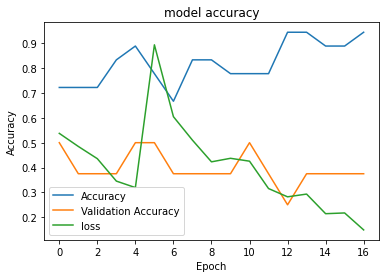

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# Metrics of the trained models

This next session is used to measure the performance of the trained models. Start from the cells below if you only want to see the results of previously trained models.

Define the three models trained to measure their metrics.

In [ ]:
saved_model = load_model(base+"videovalaccvgg16.h5")
saved_loss_model=load_model(base+"videovallossvgg16.h5")

#Uncomment the line below if you're only interested in making predictions with previously trained models.
#model=load_model(base+"videoMcCormickModel.h5")

## ROC Curve

Measure the true positive and true negative rate of the EarlyStopping model and choose the optimal threshold to make predictions. I chose to use the ROC curve for each of the different models as the threshold for later predictions.

Best Threshold=0.927147, G-Mean=0.594


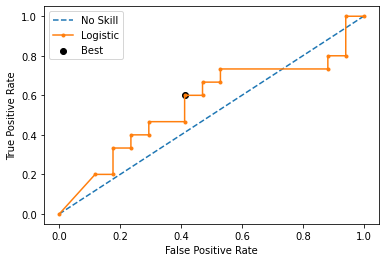

In [ ]:
from numpy import argmax
from numpy import sqrt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
# predict probabilities
testX,testy=next(traindata)
yhat = model.predict(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
Y=label_binarize(testy, classes=[0,1])
Y=Y[:,1]
# keep probabilities for the positive outcome only
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
threshold=thresholds[ix]

## Precision-Recall Curve

Measure the precision of the EarlyStopping model and choose the optimal threshold to make predictions. This precision-recall threshold is not used in future steps, but it may be better suited for other models.

Best Threshold=0.000000, F-Score=0.652


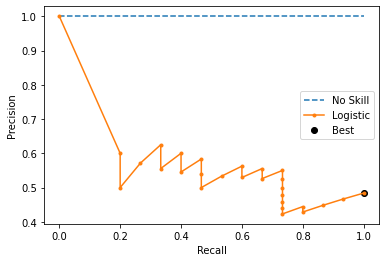

In [ ]:

# optimal threshold for precision-recall curve with logistic regression model


precision, recall, thresholds = precision_recall_curve(Y, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
#threshold=thresholds[ix]
#threshold=0.5

## Calculate F1 Score

Calculate the F1 score for the EarlyStopping model. This F1 score threshold is not used in future steps, but it may be better suited for other models.

In [ ]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Y, to_labels(yhat, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


Threshold=0.000, F-Score=0.63830


Repeat the three above measurements for the model with the highest validation accuracy...

Best Threshold=0.263158, G-Mean=0.524


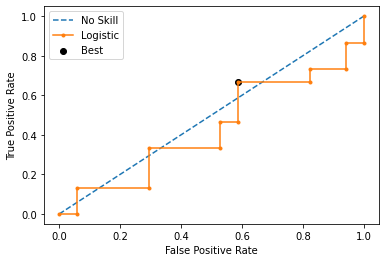

In [ ]:
from numpy import argmax
from numpy import sqrt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
# predict probabilities
yhat = saved_model.predict(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
# keep probabilities for the positive outcome only
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
threshold_saved=thresholds[ix]

Best Threshold=0.999136, F-Score=nan


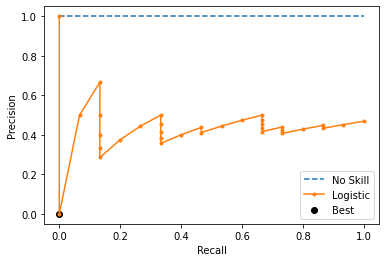

In [ ]:

# optimal threshold for precision-recall curve with logistic regression model


precision, recall, thresholds = precision_recall_curve(Y, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
#threshold_saved=thresholds[ix]
#threshold=0.5

In [ ]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Y, to_labels(yhat, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.000, F-Score=0.63830


...and for the model with the lowest validation loss.

Best Threshold=0.044456, G-Mean=0.531


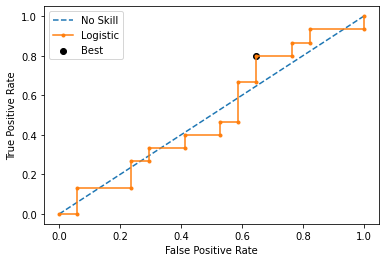

In [ ]:
from numpy import argmax
from numpy import sqrt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
# predict probabilities
yhat = saved_loss_model.predict(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
# keep probabilities for the positive outcome only
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
threshold_loss=thresholds[ix]

Best Threshold=0.999992, F-Score=nan


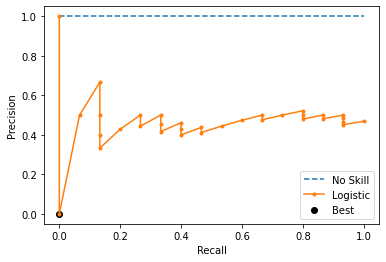

In [ ]:

# optimal threshold for precision-recall curve with logistic regression model


precision, recall, thresholds = precision_recall_curve(Y, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
#threshold=thresholds[ix]
#threshold=0.5
#threshold_loss=thresholds[ix]

In [ ]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Y, to_labels(yhat, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.002, F-Score=0.65116


In [ ]:
#Choose a manual threshold if desired
#threshold=.5

## Single Predictions

Observe how the three models predict and their confidence. The rightmost number indicates the confidence that the picture is of class 1, the leftmost number indicates the confidence is of class 0.

Damaged
[[1.0000000e+00 3.4373575e-15]]


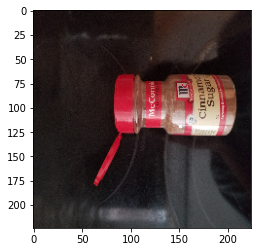

In [ ]:
img = image.load_img(base+"20210625_093141.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
if output[0][1]<threshold:
    print("Damaged")
else:
    print('Nice')
print(output)

In [ ]:
output = saved_model.predict(img)
if  output[0][1]<threshold_saved:
    print("Damaged")
else:
    print('Nice')
print(output)

Damaged
[[0.9802303  0.01976966]]


In [ ]:
output = saved_loss_model.predict(img)
if  output[0][1]<threshold_loss:
    print("Damaged")
else:
    print('Nice')
print(output)

Damaged
[[0.9981371  0.00186287]]


Damaged
[[0.99874026 0.00125977]]


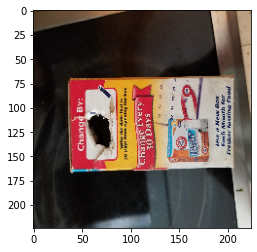

In [ ]:
img = image.load_img(base+"20210624_154904.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
if  output[0][1]<threshold:
    print("Damaged")
else:
    print('Nice')
print(output)

In [ ]:
output = saved_model.predict(img)
if  output[0][1]<threshold_saved:
    print("Damaged")
else:
    print('Nice')
print(output)

Nice
[[0.11402176 0.88597816]]


In [ ]:
output = saved_loss_model.predict(img)
if  output[0][1]<threshold_loss:
    print("Damaged")
else:
    print('Nice')
print(output)

Nice
[[0.02394039 0.9760597 ]]


Damaged
[[1.0000000e+00 3.4373575e-15]]


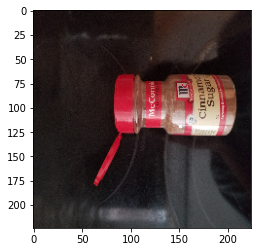

In [ ]:
img = image.load_img(base+"20210625_093141.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
if  output[0][1]<threshold:
    print("Damaged")
else:
    print('Nice')
print(output)

In [ ]:
output = saved_model.predict(img)
if  output[0][1]<threshold_saved:
    print("Damaged")
else:
    print('Nice')
print(output)

Damaged
[[0.9802303  0.01976966]]


In [ ]:
output = saved_loss_model.predict(img)
if  output[0][1]<threshold_loss:
    print("Damaged")
else:
    print('Nice')
print(output)

Damaged
[[0.9981371  0.00186287]]


## Multiple Predictions

Open up test files to observe how the model predicts images that it has not seen before.

In [ ]:
filename=[]
#Open up TestMcCormickBottles directory and extract all file names in the subdirectories
directory=base+'TestMcCormickBottles'
for dirname, blah, filenames in os.walk(directory):
    if filenames!=[]:
      filename.extend(filenames)
#print(len(filename))
#print(filename)
#write a csv file with the image_names field filled with the file names from the filename variable
csvname=base+'McCormickBottles.csv'
if os.path.isfile(csvname)==True:
  os.remove(csvname)
with open(csvname,'w') as csvfile:
  csvwriter=csv.writer(csvfile)
  csvwriter.writerow(['image_names'])
  for a in range(len(filename)):
    csvwriter.writerow([filename[a]])



In [ ]:
#Names of the test data pictures
test_set = pd.read_csv(csvname)
test_set

,image_names
0,spicelabelbraille-scaled.jpg
1,20210620_191814.jpg
2,20210620_191900.jpg
3,20210620_191903.jpg
4,20210620_191905.jpg
5,20210620_191908.jpg
6,20210620_191911.jpg
7,20210620_191919.jpg
8,20210620_191929.jpg
9,20210620_191952.jpg


In [ ]:
#Actual classes based off of human observation
actual_set = pd.read_csv(base+"ActualMcCormickClassification.csv")
actual_set
actual_set_num=[]
with open(base+'ActualMcCormickClassification.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)
#print(len(data))
for i in range(1,len(data)):
  if data[i]==['Damaged']:
    actual_set_num.append(0)
  else:
    actual_set_num.append(1)
print(actual_set_num)
#print(data[10])

[['Actual'], ['Nice'], ['Nice'], ['Nice'], ['Nice'], ['Nice'], ['Nice'], ['Nice'], ['Damaged'], ['Damaged'], ['Damaged'], ['Damaged'], ['Damaged']]
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [ ]:
#Function to create a list of file and sub directories for the test data
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 
AllFiles=[]
AllFiles = getListOfFiles(directory)
print(len(AllFiles))

12


In [ ]:
# load images and store it in numpy array
# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=model.predict(img)
    if  output[0][1]<threshold:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
print(predictions)


['Nice', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Nice', 'Damaged', 'Damaged']


In [ ]:
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
print(match_set)
actual=actual_set['Actual'].tolist()
print(actual)

<class 'list'>
['Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes']
['Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged']


In [ ]:
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Nice,Nice,Yes,"[[3.1706912e-07, 0.99999964]]"
1,20210620_191814.jpg,Damaged,Nice,No,"[[0.9725366, 0.027463326]]"
2,20210620_191900.jpg,Damaged,Nice,No,"[[1.0, 6.346435e-14]]"
3,20210620_191903.jpg,Damaged,Nice,No,"[[1.0, 1.4217218e-13]]"
4,20210620_191905.jpg,Damaged,Nice,No,"[[1.0, 6.0596934e-14]]"
5,20210620_191908.jpg,Damaged,Nice,No,"[[1.0, 1.729385e-11]]"
6,20210620_191911.jpg,Damaged,Nice,No,"[[1.0, 1.6879339e-13]]"
7,20210620_191919.jpg,Damaged,Damaged,Yes,"[[1.0, 3.587792e-10]]"
8,20210620_191929.jpg,Damaged,Damaged,Yes,"[[1.0, 2.5189315e-13]]"
9,20210620_191952.jpg,Nice,Damaged,No,"[[0.00039458356, 0.9996055]]"


Test_Set_Accuracy: 41.66666666666667%


## Confusion Matrix

Create a confusion matrix to measure other metrics of the EarlyStoppingModel.

In [ ]:
# Importing the dependancies
from sklearn import metrics
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))

[[1 6]
 [1 4]]
              precision    recall  f1-score   support

        Nice       0.50      0.14      0.22         7
     Damaged       0.40      0.80      0.53         5

    accuracy                           0.42        12
   macro avg       0.45      0.47      0.38        12
weighted avg       0.46      0.42      0.35        12



In [ ]:
test_set.to_csv(base+'McCormick_output_results.csv',index=False) #Save results


## Manual Threshold Search

Try to see if there are better results from just finding the threshold at which the best threshold would be.

In [ ]:
saved_predictions=[]
current_prediction=[]
threshold_predictions=[]
accuracies=[]
selected_elements=[]
indices=[]
length=100
for i in range(len(fulloutput)):
    current_prediction=np.array(fulloutput)[i][0][1]
    saved_predictions.append(current_prediction)
#indices=[i for i, e in enumerate(match_set) if e == 'Yes']
#for index in indices:
    #selected_elements.append(saved_predictions[index])
#print(selected_elements)
#threshold_predictions=np.linspace(min(selected_elements),max(selected_elements),length)
threshold_predictions=np.linspace(min(saved_predictions),max(saved_predictions),length)
match_set1=[]
for j in range(length):
    for i in range(len(saved_predictions)):
        if  saved_predictions[i]<threshold_predictions[j]:
            answer='Damaged'
        else:
            answer='Nice'
        if answer==actual_set['Actual'][i]:
             match_set1.append('Yes')
        else:
            match_set1.append('No')
    Test_Set_Accuracy=str(sum(condition(x) for x in match_set1)/len(match_set1)*100)
    accuracies.append(Test_Set_Accuracy)
#print(accuracies)
print('Accuracy: '+str(max(accuracies))+' %')
print('Index of Maximum Accuracy: '+str(accuracies.index(max(accuracies))))
test_threshold=threshold_predictions[accuracies.index(max(accuracies))]
print('Threshold of Maximum Accuracy: '+str(test_threshold))

#print(len(saved_predictions))
#print(saved_predictions)
#print(min(saved_predictions))
#print(max(saved_predictions))


#print(np.linspace(min(saved_predictions),max(saved_predictions),100))

Accuracy: 58.333333333333336 %
Index of Maximum Accuracy: 0
Threshold of Maximum Accuracy: 6.059693355821641e-14


In [ ]:
# load images and store it in numpy array
# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=model.predict(img)
    if  output[0][1]<test_threshold:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
#print(predictions)
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
#print(match_set)
actual=actual_set['Actual'].tolist()
#print(actual)
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

<class 'list'>


,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Nice,Nice,Yes,"[[3.1706912e-07, 0.99999964]]"
1,20210620_191814.jpg,Nice,Nice,Yes,"[[0.9725366, 0.027463326]]"
2,20210620_191900.jpg,Nice,Nice,Yes,"[[1.0, 6.346435e-14]]"
3,20210620_191903.jpg,Nice,Nice,Yes,"[[1.0, 1.4217218e-13]]"
4,20210620_191905.jpg,Nice,Nice,Yes,"[[1.0, 6.0596934e-14]]"
5,20210620_191908.jpg,Nice,Nice,Yes,"[[1.0, 1.729385e-11]]"
6,20210620_191911.jpg,Nice,Nice,Yes,"[[1.0, 1.6879339e-13]]"
7,20210620_191919.jpg,Nice,Damaged,No,"[[1.0, 3.587792e-10]]"
8,20210620_191929.jpg,Nice,Damaged,No,"[[1.0, 2.5189315e-13]]"
9,20210620_191952.jpg,Nice,Damaged,No,"[[0.00039458356, 0.9996055]]"


Test_Set_Accuracy: 58.333333333333336%


Repeat the above metrics for the model with the highest validation accuracy...

In [ ]:

# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=saved_model.predict(img)
    if  output[0][1]<threshold_saved:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
print(fulloutput)


[array([[0.9952526 , 0.00474736]], dtype=float32), array([[0.07627353, 0.9237265 ]], dtype=float32), array([[0.08342475, 0.9165752 ]], dtype=float32), array([[0.05543008, 0.9445699 ]], dtype=float32), array([[0.15569903, 0.844301  ]], dtype=float32), array([[0.6130077 , 0.38699228]], dtype=float32), array([[0.21269946, 0.78730047]], dtype=float32), array([[0.8539064 , 0.14609362]], dtype=float32), array([[0.7543827 , 0.24561724]], dtype=float32), array([[0.49743605, 0.50256395]], dtype=float32), array([[0.4099271 , 0.59007293]], dtype=float32), array([[0.6114163 , 0.38858372]], dtype=float32)]


In [ ]:
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
print(match_set)


<class 'list'>
['No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No']


In [ ]:
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Damaged,Nice,No,"[[0.9952526, 0.004747362]]"
1,20210620_191814.jpg,Nice,Nice,Yes,"[[0.07627353, 0.9237265]]"
2,20210620_191900.jpg,Nice,Nice,Yes,"[[0.083424754, 0.9165752]]"
3,20210620_191903.jpg,Nice,Nice,Yes,"[[0.055430077, 0.9445699]]"
4,20210620_191905.jpg,Nice,Nice,Yes,"[[0.15569903, 0.844301]]"
5,20210620_191908.jpg,Nice,Nice,Yes,"[[0.6130077, 0.38699228]]"
6,20210620_191911.jpg,Nice,Nice,Yes,"[[0.21269946, 0.78730047]]"
7,20210620_191919.jpg,Damaged,Damaged,Yes,"[[0.8539064, 0.14609362]]"
8,20210620_191929.jpg,Damaged,Damaged,Yes,"[[0.7543827, 0.24561724]]"
9,20210620_191952.jpg,Nice,Damaged,No,"[[0.49743605, 0.50256395]]"


Test_Set_Accuracy: 66.66666666666666%


In [ ]:
# Importing the dependancies
from sklearn import metrics
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))

[[6 1]
 [3 2]]
              precision    recall  f1-score   support

        Nice       0.67      0.86      0.75         7
     Damaged       0.67      0.40      0.50         5

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12



In [ ]:
test_set.to_csv(base+'Best_acc_McCormick_output_results.csv',index=False)


In [ ]:
saved_predictions=[]
current_prediction=[]
threshold_predictions=[]
accuracies=[]
selected_elements=[]
indices=[]
length=100
for i in range(len(fulloutput)):
    current_prediction=np.array(fulloutput)[i][0][1]
    saved_predictions.append(current_prediction)
#indices=[i for i, e in enumerate(match_set) if e == 'Yes']
#for index in indices:
    #selected_elements.append(saved_predictions[index])
#print(selected_elements)
#threshold_predictions=np.linspace(min(selected_elements),max(selected_elements),length)
threshold_predictions=np.linspace(min(saved_predictions),max(saved_predictions),length)
match_set1=[]
for j in range(length):
    for i in range(len(saved_predictions)):
        if  saved_predictions[i]<threshold_predictions[j]:
            answer='Damaged'
        else:
            answer='Nice'
        if answer==actual_set['Actual'][i]:
             match_set1.append('Yes')
        else:
            match_set1.append('No')
    Test_Set_Accuracy=str(sum(condition(x) for x in match_set1)/len(match_set1)*100)
    accuracies.append(Test_Set_Accuracy)
#print(accuracies)
print('Accuracy: '+str(max(accuracies))+' %')
print('Index of Maximum Accuracy: '+str(accuracies.index(max(accuracies))))
test_threshold=threshold_predictions[accuracies.index(max(accuracies))]
print('Threshold of Maximum Accuracy: '+str(test_threshold))

#print(len(saved_predictions))
#print(saved_predictions)
#print(min(saved_predictions))
#print(max(saved_predictions))


#print(np.linspace(min(saved_predictions),max(saved_predictions),100))

Accuracy: 68.25842696629213 %
Index of Maximum Accuracy: 88
Threshold of Maximum Accuracy: 0.840145160858002


In [ ]:
# load images and store it in numpy array
# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=saved_model.predict(img)
    if  output[0][1]<test_threshold:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
#print(predictions)
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
#print(match_set)
actual=actual_set['Actual'].tolist()
#print(actual)
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

<class 'list'>


,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Damaged,Nice,No,"[[0.9952526, 0.004747362]]"
1,20210620_191814.jpg,Nice,Nice,Yes,"[[0.07627353, 0.9237265]]"
2,20210620_191900.jpg,Nice,Nice,Yes,"[[0.083424754, 0.9165752]]"
3,20210620_191903.jpg,Nice,Nice,Yes,"[[0.055430077, 0.9445699]]"
4,20210620_191905.jpg,Nice,Nice,Yes,"[[0.15569903, 0.844301]]"
5,20210620_191908.jpg,Damaged,Nice,No,"[[0.6130077, 0.38699228]]"
6,20210620_191911.jpg,Damaged,Nice,No,"[[0.21269946, 0.78730047]]"
7,20210620_191919.jpg,Damaged,Damaged,Yes,"[[0.8539064, 0.14609362]]"
8,20210620_191929.jpg,Damaged,Damaged,Yes,"[[0.7543827, 0.24561724]]"
9,20210620_191952.jpg,Damaged,Damaged,Yes,"[[0.49743605, 0.50256395]]"


Test_Set_Accuracy: 75.0%


...and the lowest validation loss.

In [ ]:
# load images and store it in numpy array
# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=saved_loss_model.predict(img)
    if  output[0][1]<threshold_loss:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
print(fulloutput)


[array([[0.9833124 , 0.01668759]], dtype=float32), array([[0.01377664, 0.9862234 ]], dtype=float32), array([[0.8889845, 0.1110155]], dtype=float32), array([[0.31757846, 0.6824215 ]], dtype=float32), array([[0.9843157 , 0.01568426]], dtype=float32), array([[9.9998081e-01, 1.9173902e-05]], dtype=float32), array([[0.9750871 , 0.02491291]], dtype=float32), array([[9.9959797e-01, 4.0210749e-04]], dtype=float32), array([[9.9976534e-01, 2.3470802e-04]], dtype=float32), array([[0.46555775, 0.53444225]], dtype=float32), array([[0.99817157, 0.00182844]], dtype=float32), array([[0.9801209 , 0.01987905]], dtype=float32)]


In [ ]:
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
print(match_set)
actual=actual_set['Actual'].tolist()
print(actual)

<class 'list'>
['No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes']
['Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Nice', 'Damaged', 'Damaged', 'Damaged', 'Damaged', 'Damaged']


In [ ]:
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Damaged,Nice,No,"[[0.9833124, 0.016687592]]"
1,20210620_191814.jpg,Nice,Nice,Yes,"[[0.013776642, 0.9862234]]"
2,20210620_191900.jpg,Nice,Nice,Yes,"[[0.8889845, 0.1110155]]"
3,20210620_191903.jpg,Nice,Nice,Yes,"[[0.31757846, 0.6824215]]"
4,20210620_191905.jpg,Damaged,Nice,No,"[[0.9843157, 0.015684262]]"
5,20210620_191908.jpg,Damaged,Nice,No,"[[0.9999808, 1.9173902e-05]]"
6,20210620_191911.jpg,Damaged,Nice,No,"[[0.9750871, 0.024912914]]"
7,20210620_191919.jpg,Damaged,Damaged,Yes,"[[0.99959797, 0.0004021075]]"
8,20210620_191929.jpg,Damaged,Damaged,Yes,"[[0.99976534, 0.00023470802]]"
9,20210620_191952.jpg,Nice,Damaged,No,"[[0.46555775, 0.53444225]]"


Test_Set_Accuracy: 58.333333333333336%


In [ ]:
# Importing the dependancies
from sklearn import metrics
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(actual_set['Actual'], predictions, labels=["Nice", "Damaged"]))

[[3 4]
 [1 4]]
              precision    recall  f1-score   support

        Nice       0.75      0.43      0.55         7
     Damaged       0.50      0.80      0.62         5

    accuracy                           0.58        12
   macro avg       0.62      0.61      0.58        12
weighted avg       0.65      0.58      0.57        12



In [ ]:
test_set.to_csv(base+'Best_loss_McCormick_output_results.csv',index=False)


In [ ]:
saved_predictions=[]
current_prediction=[]
threshold_predictions=[]
accuracies=[]
selected_elements=[]
indices=[]
length=100
for i in range(len(fulloutput)):
    current_prediction=np.array(fulloutput)[i][0][1]
    saved_predictions.append(current_prediction)
#indices=[i for i, e in enumerate(match_set) if e == 'Yes']
#for index in indices:
    #selected_elements.append(saved_predictions[index])
#print(selected_elements)
#threshold_predictions=np.linspace(min(selected_elements),max(selected_elements),length)
threshold_predictions=np.linspace(min(saved_predictions),max(saved_predictions),length)
match_set1=[]
for j in range(length):
    for i in range(len(saved_predictions)):
        if  saved_predictions[i]<threshold_predictions[j]:
            answer='Damaged'
        else:
            answer='Nice'
        if answer==actual_set['Actual'][i]:
             match_set1.append('Yes')
        else:
            match_set1.append('No')
    Test_Set_Accuracy=str(sum(condition(x) for x in match_set1)/len(match_set1)*100)
    accuracies.append(Test_Set_Accuracy)
#print(accuracies)
print('Accuracy: '+str(max(accuracies))+' %')
print('Index of Maximum Accuracy: '+str(accuracies.index(max(accuracies))))
test_threshold=threshold_predictions[accuracies.index(max(accuracies))]
print('Threshold of Maximum Accuracy: '+str(test_threshold))

#print(len(saved_predictions))
#print(saved_predictions)
#print(min(saved_predictions))
#print(max(saved_predictions))


#print(np.linspace(min(saved_predictions),max(saved_predictions),100))

Accuracy: 66.66666666666666 %
Index of Maximum Accuracy: 1
Threshold of Maximum Accuracy: 0.009980832747650577


In [ ]:
# load images and store it in numpy array
# empty list to store the images
predictions=[]
fulloutput=[]
# iterating over each image
#for i in range(100):
for i in range(len(AllFiles)):
    #count += 1
    # loading the image using its name
    img = image.load_img(AllFiles[i],target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    #print (rsize.shape)
    # saving each image in the list
    #plt.show()
    output=saved_model.predict(img)
    if  output[0][1]<test_threshold:
      answer='Damaged'
    else:
      answer='Nice'
    #print(answer)
    predictions.append(answer)
    fulloutput.append(output)
#print(predictions)
# converting the list of images into array
#NewX=np.array(NewX)
#print(predictions)
#Check to see if predictions match actual
match_set=[]
print(type(predictions))
for i in range(len(predictions)):
  if predictions[i]==actual_set['Actual'][i]:
    match_set.append('Yes')
  else:
    match_set.append('No')
#print(match_set)
actual=actual_set['Actual'].tolist()
#print(actual)
test_set['class'] = predictions
test_set['actual']=actual_set['Actual']
test_set['Match?']=match_set
test_set['Confidence Score']=fulloutput
display(test_set)
def condition(x):
  return x =='Yes'
# Count the number of matching elements
Test_Set_Accuracy=str(sum(condition(x) for x in match_set)/len(match_set)*100)
print('Test_Set_Accuracy: '+Test_Set_Accuracy+'%')

<class 'list'>


,image_names,class,actual,Match?,Confidence Score
0,spicelabelbraille-scaled.jpg,Damaged,Nice,No,"[[0.9952526, 0.004747362]]"
1,20210620_191814.jpg,Nice,Nice,Yes,"[[0.07627353, 0.9237265]]"
2,20210620_191900.jpg,Nice,Nice,Yes,"[[0.083424754, 0.9165752]]"
3,20210620_191903.jpg,Nice,Nice,Yes,"[[0.055430077, 0.9445699]]"
4,20210620_191905.jpg,Nice,Nice,Yes,"[[0.15569903, 0.844301]]"
5,20210620_191908.jpg,Nice,Nice,Yes,"[[0.6130077, 0.38699228]]"
6,20210620_191911.jpg,Nice,Nice,Yes,"[[0.21269946, 0.78730047]]"
7,20210620_191919.jpg,Nice,Damaged,No,"[[0.8539064, 0.14609362]]"
8,20210620_191929.jpg,Nice,Damaged,No,"[[0.7543827, 0.24561724]]"
9,20210620_191952.jpg,Nice,Damaged,No,"[[0.49743605, 0.50256395]]"


Test_Set_Accuracy: 50.0%


## Predictions on Video

This section shows how the EarlyStopping model predicts from a video. The video can either be a saved video or be a live feed from your webcam. The window_size specifies how many frames should have their predictions averaged together to incorporate the temporal nature of a video. Basically, the window_size helps to increase the consistency of the predictions by taking the overall average as the actual average for a certain span of time.

In [ ]:
#threshold=0.5

In [ ]:
#Define a function for attaching and saving predictions based off of a video. 
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
    color=[]
    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 
        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))
    
        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Accessing The Class Name using predicted label.
            if  predicted_labels_probabilities_averaged[0][1]<threshold:
              predicted_class_name = 'Damaged'
            else:
              predicted_class_name = 'Nice'
          
            # Overlaying Class Name Text Ontop of the Frame, changing color to reflect whether the bottle is defective or not
            if predicted_class_name=='Damaged':
              color=(0, 0, 255)
            else:
              color=(0,255,0)

            cv2.putText(frame, predicted_class_name, (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
            cv2.putText(frame,  str(predicted_labels_probabilities), (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, color , 2)
        # Writing The Frame
        video_writer.write(frame)


        #cv2.imshow('Predicted Frames', frame)

        #key_pressed = cv2.waitKey(1)

        #if key_pressed == 27:
          #break

    cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
#Specify parameters for the predict_on_live_video function and display the results below.
image_height, image_width = 224, 224
max_images_per_class = 8000

output_directory=base+'ClassifiedVideo'
video_title='Defect_Video'
window_size=25
#Set input_video_file_path to 0 to use webcam
input_video_file_path=base+'McCormickVideo/IMG_8495.MOV'
#input_video_file_path=0
output_video_file_path = f'{output_directory}\\{video_title}{window_size}.mp4'
print(output_video_file_path)
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
cool_video=VideoFileClip(output_video_file_path)
ipython_display(cool_video, width=700)
